<a href="https://colab.research.google.com/github/Spookytober/Datascience/blob/main/Aubr_OrfU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Cardinalis cardinalis* mass in relation to region

I chose to do my project with a similar topic and dataset to my unit 3 project. My question was about Cardinal masses. I wanted to know how Northern Cardinal masses are affected by region. This dataset had cardinal masses across four regions: Ohio, New York, Mississippi, and Florida.

In [1]:
#Importing needed libraries.
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In [2]:
#importing dataset
url_mxl = 'https://raw.githubusercontent.com/Spookytober/Datascience/refs/heads/main/mass%20x%20location%20-%20Northern%20Cardinal%20data.csv'
mxl_data = pd.read_csv(url_mxl,dtype={'location':'category'})
#converting to categories
loc_idx = mxl_data.location.cat.codes.values
loc_codes = mxl_data.location.cat.categories
mxl_coords = {'loc': loc_codes}

In [ ]:
mxl_data

,location,mass
0,Ohio,43.3
1,Ohio,44.8
2,Ohio,44.0
3,Ohio,44.7
4,Ohio,42.2
...,...,...
427,Florida,38.1
428,Florida,31.7
429,Florida,34.6
430,Florida,33.7


Here is my dataset. Next, I wanted to visualize my data, so I used a violin plot. The reason I used a violin plot instead of some other way to visualize this was because violin plots make it really easy to see the mean, if there's any skew in the data, and the shape of the data.

<Axes: xlabel='mass', ylabel='location'>

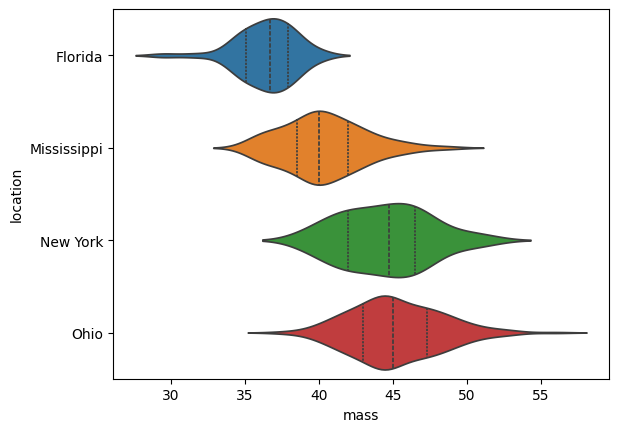

In [ ]:
sns.violinplot(mxl_data, x='mass', y='location', inner='quart',hue='location')

<Axes: >

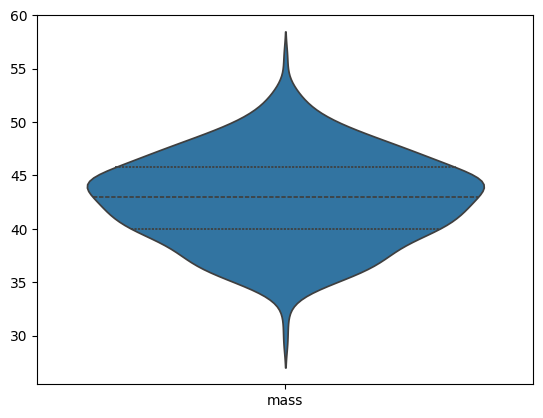

In [ ]:
sns.violinplot(mxl_data, inner = 'quart')

The first violin plot by region I made mainly to compare with the final plot forest later. I think it is interesting to note, though, how different the values are between regions. It seems to me as if Northern Cardinal mass increases with latitude. Florida is lower then Mississippi which is lower than New York, but New York and Ohio are at very similar latitudes. My final model kept this distinction with the masses increasing by latitude.

The second violin plot informed how I created my models. Looking at this plot, you can see the mean of the data is around 43 grams, and it looks a lot like a normal distribution. I said most of the data was within 10 grams of the mean, meaning sigma would be 5. The first model I tried using was with a non-hierarchical Normal distribution, because I wasn't sure if there was dependence between regions.

In [10]:
#Using a non-hierarchical Normal model
with pm.Model(coords = mxl_coords) as mxl_nhN_model:
  μ = pm.Normal('μ', mu = 43, sigma = 5, dims = 'loc')
  σ = pm.HalfNormal("σ", sigma = 5, dims ='loc')
  y = pm.Normal('y', mu =μ[loc_idx], sigma = σ[loc_idx], observed = mxl_data.mass)
  idata_mxl_nhN = pm.sample()

Output()

Output()

Output()

<Axes: xlabel='y'>

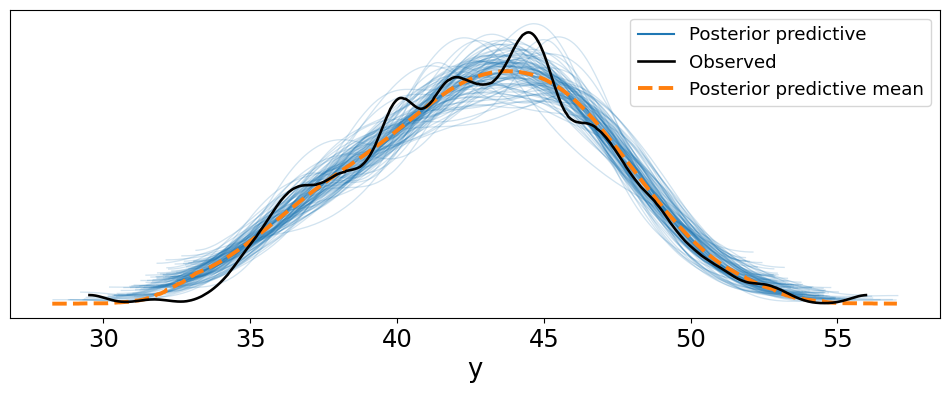

In [11]:
pm.sample_posterior_predictive(idata_mxl_nhN, model = mxl_nhN_model, extend_inferencedata=True)
az.plot_ppc(idata_mxl_nhN, num_pp_samples=100, figsize=(12,4))

The non-hierarchical Normal ended up fitting my observed data very nicely when I tested it using a Posterior Predictive Check. This means that, like most biology data, my dataset can be well represented using a Normal distribution.

In [3]:
#Using a hierarchical Normal model
with pm.Model(coords = mxl_coords) as mxl_hN_model:
  μ_mu = pm.Normal("μ_mu", mu = 43, sigma = 5)
  μ_sig = pm.HalfNormal("μ_sig", sigma = 5)
  μ = pm.Normal('μ', mu = μ_mu, sigma = μ_sig, dims = 'loc')
  σ = pm.HalfNormal("σ", sigma = 5, dims ='loc')
  y = pm.Normal('y', mu =μ[loc_idx], sigma = σ[loc_idx], observed = mxl_data.mass)
  idata_mxl_hN = pm.sample(target_accept = .95)

Output()

Output()

Output()

<Axes: xlabel='y'>

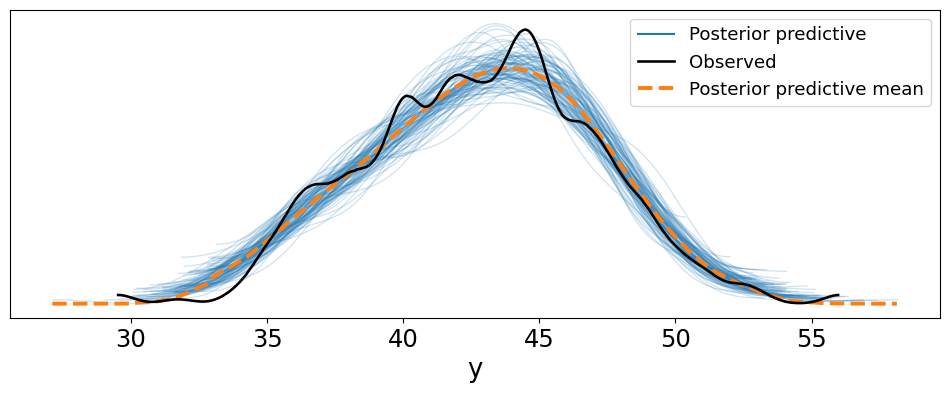

In [5]:
pm.sample_posterior_predictive(idata_mxl_hN, model = mxl_hN_model, extend_inferencedata=True)
az.plot_ppc(idata_mxl_hN, num_pp_samples=100, figsize=(12,4))

I wanted to see if there was dependence between groups, but I still am not sure if that's the case, because the hierarchical Normal model resulted in almost the same posterior predictive mean.

In [4]:
#Using a hierarchical Student-T model
with pm.Model(coords=mxl_coords) as mxl_hT_model:
    μ_nu = pm.Exponential('μ_nu', lam=1/30)
    μ_mu = pm.StudentT('μ_mu', nu=1, mu = 43, sigma = 5)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 5, nu=1)
    μ = pm.StudentT('μ', mu = μ_mu, nu = μ_nu, sigma = μ_sd,dims = "loc")
    σ = pm.HalfNormal('σ', sigma = 5, dims = "loc")
    v = pm.Exponential('v', lam=1/30)
    y = pm.StudentT('y',nu=v , mu = μ[loc_idx],sigma = σ[loc_idx],observed = mxl_data.mass)
    idata_mxl_hT = pm.sample(target_accept = 0.95)

Output()

Output()

Output()

<Axes: xlabel='y'>

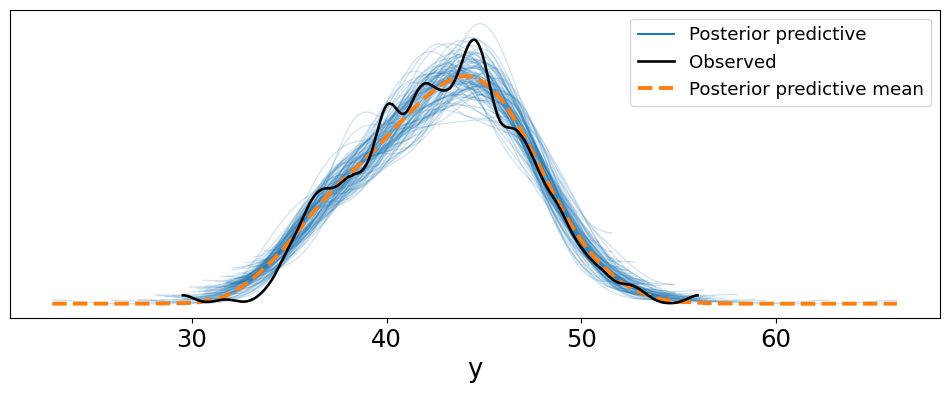

In [6]:
pm.sample_posterior_predictive(idata_mxl_hT, model = mxl_hT_model, extend_inferencedata=True)
az.plot_ppc(idata_mxl_hT, num_pp_samples=100, figsize=(12,4))

I wanted to test what my data would look like if I used a hierarchical Student-T distribution too. The student T distribution has longer tails than the two Normal distributions. It's hard to tell with this PPC, but in the following plot forest you can see that the Student-T was different from the other Normal distributions.

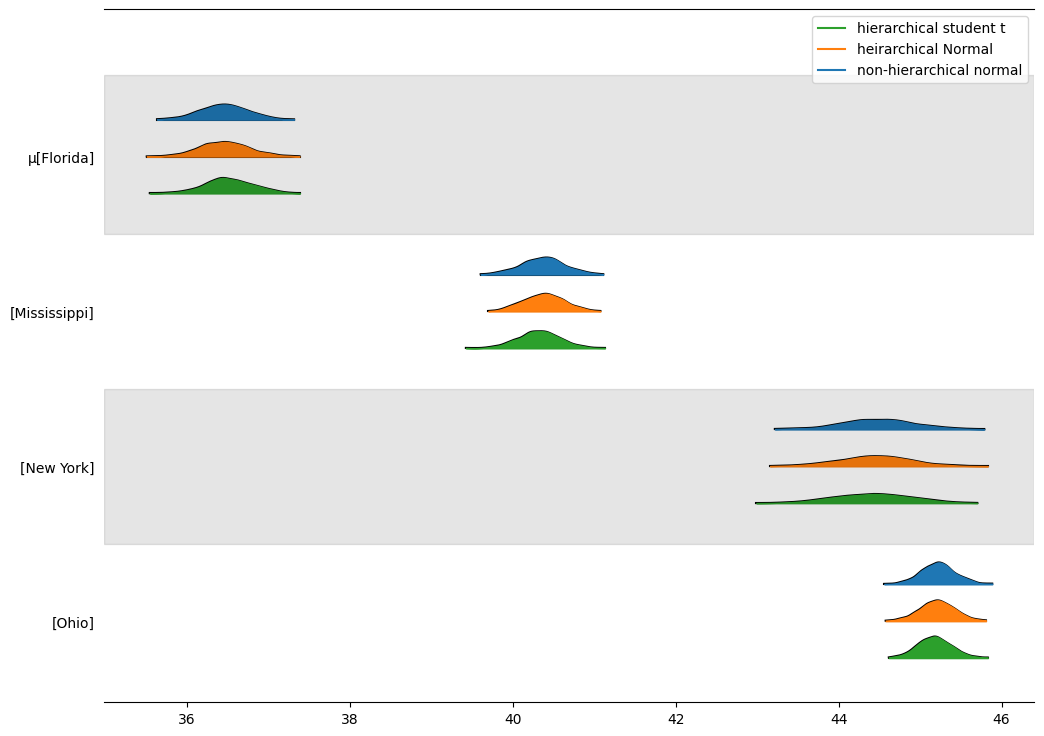

In [ ]:
axes = az.plot_forest([idata_mxl_nhN, idata_mxl_hN, idata_mxl_hT], kind="ridgeplot", model_names=['non-hierarchical normal', 'heirarchical Normal', 'hierarchical student t'],var_names='μ',combined=True, figsize=(12, 9), hdi_prob=0.997)

My final forest plot is featured above. It compares the three models that I tested. Since the regions had different sample sizes, the areas with more samples have less variance and deviation. New York has the lowest number of data points, and as such the model can't be sure about its predictions, so it's spread further thin over more masses.

The Student-T distribution is offset from the other two distributions I used, which is because the T distribution is better at ignoring outliers. According to this model, there are outliers in the data that raise the masses of birds in New York and Mississippi.

The data and my model are both in agreement that mass varies by latitude, with Northern Cardinals in lower latitudes having lower masses. Florida's birds have the lowest masses, with the mean of Floridian Cardinal mass being around 36.5 grams. Mississippian birds have a higher average mass at around 40.5 grams. New Yorker birds had an average mass of around 44.4 (with a lot of room for error there), and Ohioan birds had an average mass of around 45, according to my model.

I think the Student-T model applies best to this data set, because it ignores outlying data, yet isn't too dissimilar to the other models to be outlandish.